# SEA-AD: Gene GNN Analysis

**Goal:** Analyze the **Gene GNN** trained on the co-expression network.
This model learns low-dimensional embeddings (32d) for genes based on their co-expression patterns across the ~1.2M cells.

**Files:**
- Graph: `data/processed/graphs/gene_graph.pt`
- Model: `outputs/gene_model.ckpt`

**Analysis:**
1. Load Graph & Model
2. Generate Gene Embeddings (GPU)
3. Cluster Genes (Leiden) to identify functional modules
4. Visualize with UMAP

In [1]:
import os
# Fix OpenMP conflict on Windows (OMP Error #15)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn.functional as F
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Add src to path
sys.path.append(os.path.abspath('../src'))
from models.gnn_models import GeneGNN

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)

# Force GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 1. Load Gene Graph
Loads the processed gene co-expression graph.

In [2]:
data_path = '../data/processed/graphs/gene_graph.pt'

if os.path.exists(data_path):
    print(f"Loading graph from {data_path}...")
    # Loading with weights_only=False for PyG Data objects
    try:
        data = torch.load(data_path, weights_only=False)
    except TypeError:
        data = torch.load(data_path)
        
    print(f"Graph Statistics:")
    print(f"  - Nodes (Genes): {data.num_nodes}")
    print(f"  - Features: {data.num_features}")
    print(f"  - Edges: {data.num_edges}")
else:
    print(f"Error: {data_path} not found. Run build_graphs.py first.")

Loading graph from ../data/processed/graphs/gene_graph.pt...
Graph Statistics:
  - Nodes (Genes): 2000
  - Features: 2
  - Edges: 449054


### 2. Load Trained Model
Loads the `GeneGNN` checkpoint. This model outputs embeddings, not classifications.

In [3]:
ckpt_path = '../outputs/gene_model.ckpt'

if os.path.exists(ckpt_path) and 'data' in locals():
    print(f"Loading model from {ckpt_path}...")
    
    # Initialize model (Must match training config in train.py)
    # GeneGNN(in_channels, hidden=64, out=32)
    model = GeneGNN(in_channels=data.num_features, hidden_channels=64, out_channels=32)
    
    try:
        checkpoint = torch.load(ckpt_path, map_location=device)
        # Handle Lightning checkpoint format
        if 'state_dict' in checkpoint:
            state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
        else:
            state_dict = checkpoint
            
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        print("Model loaded and moved to GPU.")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
else:
    print("Checkpoint or Data missing.")

Loading model from ../outputs/gene_model.ckpt...
Model loaded and moved to GPU.


### 3. Generate Embeddings (GPU)
Run the GNN to get the latent representation for each gene.

In [4]:
if 'model' in locals() and 'data' in locals():
    print("Running inference on GPU...")
    data = data.to(device)
    
    with torch.no_grad():
        # Get Embeddings
        embeddings = model(data.x, data.edge_index)
        embeddings_np = embeddings.cpu().numpy()
        
    print(f"Embeddings shape: {embeddings_np.shape}")

Running inference on GPU...
Embeddings shape: (2000, 32)


### 4. Cluster & Visualize (UMAP)
We use Scanpy to treat the genes as 'observations' to leverage its UMAP and clustering tools.
We cluster genes to see if they form functional modules.

Computing Neighbors & UMAP on Gene Embeddings...


c:\Users\thoma\miniconda3\envs\brain-gnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Clustering Genes (Leiden)...
Plotting Gene Modules...


C:\Users\thoma\AppData\Local\Temp\ipykernel_19092\2033378775.py:17: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_genes, resolution=0.5, key_added='Module')


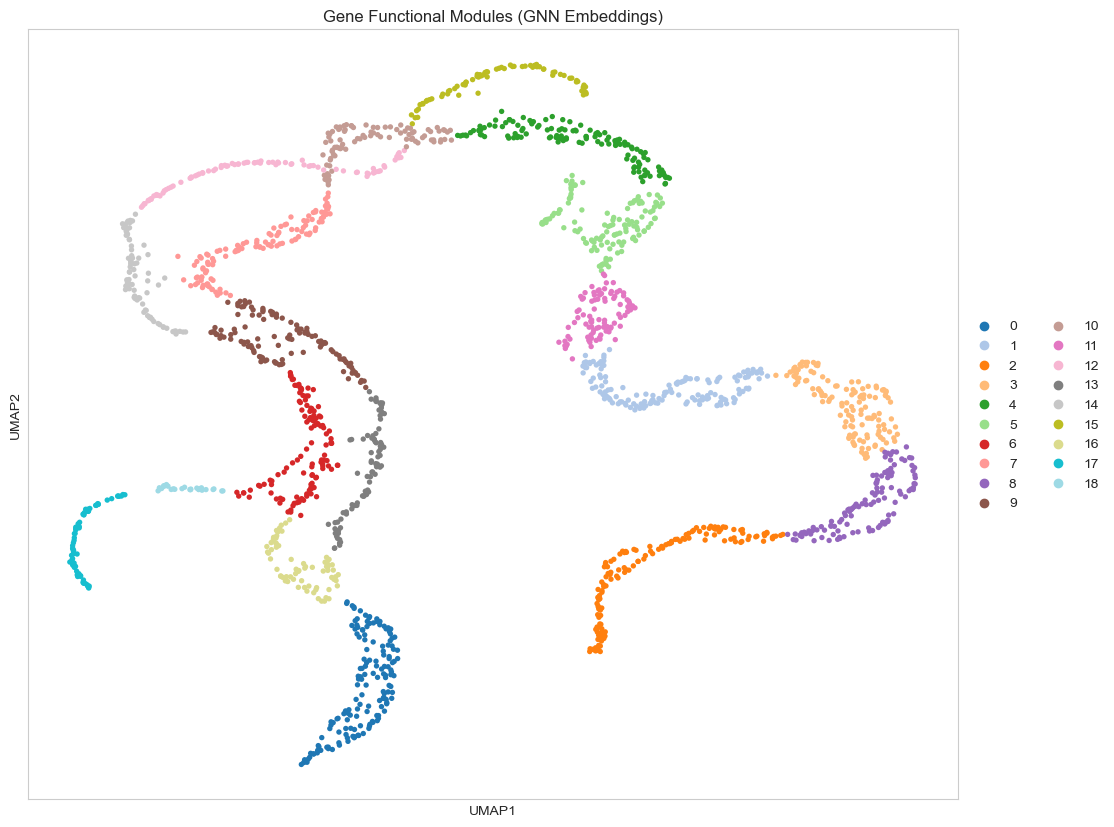

In [5]:
# Create AnnData for Genes (genes are observations here)
adata_genes = sc.AnnData(X=embeddings_np)
if hasattr(data, 'gene_names') and data.gene_names is not None:
    # data.gene_names might be a list or array
    if isinstance(data.gene_names, list):
         adata_genes.obs_names = data.gene_names
    else:
         # It might be in the loaded object differently if saved from PyG, 
         # but let's assume index match implies order.
         pass

print("Computing Neighbors & UMAP on Gene Embeddings...")
sc.pp.neighbors(adata_genes, use_rep='X', n_neighbors=15)
sc.tl.umap(adata_genes)

print("Clustering Genes (Leiden)...")
sc.tl.leiden(adata_genes, resolution=0.5, key_added='Module')

# Plot
print("Plotting Gene Modules...")
sc.pl.umap(adata_genes, color=['Module'], title='Gene Functional Modules (GNN Embeddings)', palette='tab20')
plt.show()